In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_io as tfio
import functools
from pedalboard import load_plugin
from ReverberatorEstimator import layers, loss
import warnings
warnings.filterwarnings('ignore')
import time
import os
import librosa.display
import datetime

2.6.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 3 Logical GPUs


2021-12-15 12:00:25.326828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 3, name: GeForce GT 710, pci bus id: 0000:02:00.0, compute capability: 3.5) with core count: 1. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2021-12-15 12:00:25.328386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-15 12:00:27.111400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11432 MB memory:  -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2021-12-15 12:00:27.112655: I tensorflow/core/common_runtime/gpu/gpu_

In [3]:
sample_rate = 48000
num_params = 112
batch_size = 8

In [4]:
target_audio = tfio.audio.AudioIOTensor("Dataset/Wet/Snap_16ch.wav")
target_audio = target_audio.to_tensor()
target_audio = tf.slice(target_audio, begin=[0,0], size=[-1,1])
target_audio = tf.cast(target_audio, tf.float32) / 32768.0
target_audio = tf.squeeze(target_audio)
target_audio = tf.reshape(target_audio,(1, 96000))
input_audio = tfio.audio.AudioIOTensor("Dataset/Dry/New.wav")
input_audio = input_audio.to_tensor()
input_audio = tf.slice(input_audio, begin=[0,0], size=[-1,1])
input_audio = tf.cast(input_audio, tf.float32) / 32768.0
input_audio = tf.squeeze(input_audio)
input_audio = tf.reshape(input_audio,(1, 96000))

2021-12-15 12:00:27.165634: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [5]:
dataset_path = os.path.abspath("./Dataset")

dry_files = []

for f in range(batch_size):
    audio = tfio.audio.AudioIOTensor(dataset_path + "/Dry/New.wav")
    audio = audio.to_tensor()
    audio = tf.slice(audio, begin=[0,0], size=[-1,1])
    audio = tf.cast(audio, tf.float32) / 32768.0
    audio = tf.squeeze(audio)
    audio = tf.reshape(audio,(96000))
    dry_files.append(audio)
    
x_train = tf.stack(dry_files)

wet_files = []

for f in range(batch_size):
    audio = tfio.audio.AudioIOTensor(dataset_path + "/Wet/Snap_16ch.wav")
    audio = audio.to_tensor()
    audio = tf.slice(audio, begin=[0,0], size=[-1,1])
    audio = tf.cast(audio, tf.float32) / 32768.0
    audio = tf.squeeze(audio)
    audio = tf.reshape(audio,(96000))
    wet_files.append(audio)
    
y_train = tf.stack(wet_files)

In [6]:
logmelgram = layers.LogMelgramLayer(1024, 256, 128, sample_rate, 0.0, sample_rate//2, 1e-6)
audio_time = tfkl.Input(shape=(96000,), name="audio_time")

x = logmelgram(audio_time)
x = tfkl.BatchNormalization(name="input_norm")(x)
encoder_model = tfk.applications.MobileNetV2(input_shape=(x.shape[1], x.shape[2], x.shape[3]), alpha=1.0,
                                            include_top=True, weights=None, input_tensor=None, pooling=None,
                                            classes=np.sum(num_params).item(), classifier_activation="sigmoid")

hidden = encoder_model(x)

parameter_model = tfk.models.Model(audio_time, hidden, name="parameter_model")

parameters = parameter_model(audio_time)

vstlayer = layers.VSTProcessor("./Reverberator.vst3", sample_rate)
output = vstlayer([audio_time, parameters])

model = tfk.models.Model(audio_time, output, name="full_model")

spectral_loss = loss.multiScaleSpectralLoss(loss_type='L2', 
                                            mag_weight=1., 
                                            logmag_weight=1., 
                                            time_loss=True, 
                                            time_loss_type='L1', 
                                            time_loss_weight=1.0,
                                            delta_freq_weight=1.0,
                                            fft_sizes=(1024,512,256),
                                            overlap=0.0,
                                            batch_size=batch_size,
                                            sr=sample_rate,)
                                              
optimizer = tfk.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=spectral_loss, metrics=['mae'], run_eagerly=True)

No protocol specified
No protocol specified
No protocol specified
No protocol specified


In [7]:
parameter_model.summary()
model.summary()

Model: "parameter_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_time (InputLayer)      [(None, 96000)]           0         
_________________________________________________________________
log_melgram_layer (LogMelgra (None, 372, 128, 1)       0         
_________________________________________________________________
input_norm (BatchNormalizati (None, 372, 128, 1)       4         
_________________________________________________________________
mobilenetv2_1.00_372 (Functi (None, 112)               2400880   
Total params: 2,400,884
Trainable params: 2,366,770
Non-trainable params: 34,114
_________________________________________________________________
Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio_time (Inpu

In [8]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                  factor=0.5,
                                  patience=10,
                                  cooldown=0,
                                  verbose=1,
                                  mode='auto',
                                  min_lr=0.0000016)

In [9]:
# Restore from latest checkpoint
try:
    model.load_weights(checkpoint_path)
except:
    print("No previous checkpoints found at %s" % checkpoint_path)

No previous checkpoints found at checkpoints/cp.ckpt


In [10]:
audio_pre = (model.call(input_audio)).numpy()[0]
old_params = parameter_model(input_audio).numpy()[0]
print(old_params)

2021-12-15 12:00:31.986385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2021-12-15 12:00:32.288009: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5]


In [11]:
start_time = time.time()
history = model.fit(x_train, y_train, verbose=1, epochs=500,
         callbacks=[model_cp,reduce_lr])
print("Training took %d seconds" % (time.time() - start_time))

Epoch 1/500


2021-12-15 12:00:32.585099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 30s 30s/step - loss: 10.7257 - mae: 0.0157

Epoch 00001: loss improved from inf to 10.72574, saving model to checkpoints/cp.ckpt
Epoch 2/500
1/1 [==============================] - 30s 30s/step - loss: 16.2010 - mae: 0.0183

Epoch 00002: loss did not improve from 10.72574
Epoch 3/500
1/1 [==============================] - 29s 29s/step - loss: 14.8084 - mae: 0.0165

Epoch 00003: loss did not improve from 10.72574
Epoch 4/500
1/1 [==============================] - 29s 29s/step - loss: 6.7406 - mae: 0.0128

Epoch 00004: loss improved from 10.72574 to 6.74064, saving model to checkpoints/cp.ckpt
Epoch 5/500
1/1 [==============================] - 29s 29s/step - loss: 6.0334 - mae: 0.0180

Epoch 00005: loss improved from 6.74064 to 6.03336, saving model to checkpoints/cp.ckpt
Epoch 6/500
1/1 [==============================] - 29s 29s/step - loss: 37.8082 - mae: 0.0543

Epoch 00006: loss did not improve from 6.03336
Epoch 7/500
1/1 [======================

Epoch 53/500
1/1 [==============================] - 29s 29s/step - loss: 4.1310 - mae: 0.0166

Epoch 00053: loss did not improve from 4.10331
Epoch 54/500
1/1 [==============================] - 29s 29s/step - loss: 4.1116 - mae: 0.0164

Epoch 00054: loss did not improve from 4.10331
Epoch 55/500
1/1 [==============================] - 29s 29s/step - loss: 4.1078 - mae: 0.0165

Epoch 00055: loss did not improve from 4.10331
Epoch 56/500
1/1 [==============================] - 29s 29s/step - loss: 4.0620 - mae: 0.0164

Epoch 00056: loss improved from 4.10331 to 4.06204, saving model to checkpoints/cp.ckpt
Epoch 57/500
1/1 [==============================] - 29s 29s/step - loss: 4.0626 - mae: 0.0165

Epoch 00057: loss did not improve from 4.06204
Epoch 58/500
1/1 [==============================] - 29s 29s/step - loss: 4.0528 - mae: 0.0165

Epoch 00058: loss improved from 4.06204 to 4.05280, saving model to checkpoints/cp.ckpt
Epoch 59/500
1/1 [==============================] - 29s 29s/step -

1/1 [==============================] - 29s 29s/step - loss: 3.6833 - mae: 0.0143

Epoch 00105: loss improved from 3.71041 to 3.68326, saving model to checkpoints/cp.ckpt
Epoch 106/500
1/1 [==============================] - 29s 29s/step - loss: 3.6458 - mae: 0.0143

Epoch 00106: loss improved from 3.68326 to 3.64576, saving model to checkpoints/cp.ckpt
Epoch 107/500
1/1 [==============================] - 29s 29s/step - loss: 3.6378 - mae: 0.0147

Epoch 00107: loss improved from 3.64576 to 3.63784, saving model to checkpoints/cp.ckpt
Epoch 108/500
1/1 [==============================] - 29s 29s/step - loss: 3.6956 - mae: 0.0149

Epoch 00108: loss did not improve from 3.63784
Epoch 109/500
1/1 [==============================] - 29s 29s/step - loss: 3.7106 - mae: 0.0148

Epoch 00109: loss did not improve from 3.63784
Epoch 110/500
1/1 [==============================] - 29s 29s/step - loss: 3.7170 - mae: 0.0151

Epoch 00110: loss did not improve from 3.63784
Epoch 111/500
1/1 [==============

1/1 [==============================] - 30s 30s/step - loss: 3.5104 - mae: 0.0140

Epoch 00158: loss did not improve from 3.44707
Epoch 159/500
1/1 [==============================] - 30s 30s/step - loss: 3.5104 - mae: 0.0140

Epoch 00159: loss did not improve from 3.44707
Epoch 160/500
1/1 [==============================] - 30s 30s/step - loss: 3.5104 - mae: 0.0140

Epoch 00160: loss did not improve from 3.44707
Epoch 161/500
1/1 [==============================] - 30s 30s/step - loss: 3.5227 - mae: 0.0139

Epoch 00161: loss did not improve from 3.44707
Epoch 162/500
1/1 [==============================] - 29s 29s/step - loss: 3.5227 - mae: 0.0139

Epoch 00162: loss did not improve from 3.44707
Epoch 163/500
1/1 [==============================] - 29s 29s/step - loss: 3.5227 - mae: 0.0139

Epoch 00163: loss did not improve from 3.44707
Epoch 164/500
1/1 [==============================] - 29s 29s/step - loss: 3.5227 - mae: 0.0139

Epoch 00164: loss did not improve from 3.44707
Epoch 165/500


Epoch 00212: loss did not improve from 3.44707
Epoch 213/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00213: loss did not improve from 3.44707
Epoch 214/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00214: loss did not improve from 3.44707
Epoch 215/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00215: loss did not improve from 3.44707
Epoch 216/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00216: loss did not improve from 3.44707
Epoch 217/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00217: loss did not improve from 3.44707
Epoch 218/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

Epoch 00218: loss did not improve from 3.44707
Epoch 219/500
1/1 [==============================] - 30s 30s/step - loss: 3.5031 - mae: 0.0141

1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00270: loss did not improve from 3.44707
Epoch 271/500
1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00271: loss did not improve from 3.44707
Epoch 272/500
1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00272: loss did not improve from 3.44707
Epoch 273/500
1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00273: loss did not improve from 3.44707
Epoch 274/500
1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00274: loss did not improve from 3.44707
Epoch 275/500
1/1 [==============================] - 30s 30s/step - loss: 3.4734 - mae: 0.0134

Epoch 00275: loss did not improve from 3.44707
Epoch 276/500
1/1 [==============================] - 30s 30s/step - loss: 3.5065 - mae: 0.0140

Epoch 00276: loss did not improve from 3.44707
Epoch 277/500

1/1 [==============================] - 30s 30s/step - loss: 3.4635 - mae: 0.0135

Epoch 00327: loss did not improve from 3.44707
Epoch 328/500
1/1 [==============================] - 30s 30s/step - loss: 3.4635 - mae: 0.0135

Epoch 00328: loss did not improve from 3.44707
Epoch 329/500
1/1 [==============================] - 30s 30s/step - loss: 3.4626 - mae: 0.0134

Epoch 00329: loss did not improve from 3.44707
Epoch 330/500
1/1 [==============================] - 30s 30s/step - loss: 3.5303 - mae: 0.0140

Epoch 00330: loss did not improve from 3.44707
Epoch 331/500
1/1 [==============================] - 30s 30s/step - loss: 3.5303 - mae: 0.0140

Epoch 00331: loss did not improve from 3.44707
Epoch 332/500
1/1 [==============================] - 30s 30s/step - loss: 3.5303 - mae: 0.0140

Epoch 00332: loss did not improve from 3.44707
Epoch 333/500
1/1 [==============================] - 30s 30s/step - loss: 3.5065 - mae: 0.0140

Epoch 00333: loss did not improve from 3.44707
Epoch 334/500

1/1 [==============================] - 30s 30s/step - loss: 3.4730 - mae: 0.0135

Epoch 00384: loss did not improve from 3.44707
Epoch 385/500
1/1 [==============================] - 30s 30s/step - loss: 3.4730 - mae: 0.0135

Epoch 00385: loss did not improve from 3.44707
Epoch 386/500
1/1 [==============================] - 30s 30s/step - loss: 3.4730 - mae: 0.0135

Epoch 00386: loss did not improve from 3.44707
Epoch 387/500
1/1 [==============================] - 30s 30s/step - loss: 3.4730 - mae: 0.0135

Epoch 00387: loss did not improve from 3.44707
Epoch 388/500
1/1 [==============================] - 30s 30s/step - loss: 3.4730 - mae: 0.0135

Epoch 00388: loss did not improve from 3.44707
Epoch 389/500
1/1 [==============================] - 31s 31s/step - loss: 3.5031 - mae: 0.0141

Epoch 00389: loss did not improve from 3.44707
Epoch 390/500
1/1 [==============================] - 31s 31s/step - loss: 3.5031 - mae: 0.0141

Epoch 00390: loss did not improve from 3.44707
Epoch 391/500

1/1 [==============================] - 30s 30s/step - loss: 3.5089 - mae: 0.0141

Epoch 00441: loss did not improve from 3.44707
Epoch 442/500
1/1 [==============================] - 30s 30s/step - loss: 3.5089 - mae: 0.0141

Epoch 00442: loss did not improve from 3.44707
Epoch 443/500
1/1 [==============================] - 31s 31s/step - loss: 3.5089 - mae: 0.0141

Epoch 00443: loss did not improve from 3.44707
Epoch 444/500
1/1 [==============================] - 30s 30s/step - loss: 3.4899 - mae: 0.0141

Epoch 00444: loss did not improve from 3.44707
Epoch 445/500
1/1 [==============================] - 30s 30s/step - loss: 3.4899 - mae: 0.0141

Epoch 00445: loss did not improve from 3.44707
Epoch 446/500
1/1 [==============================] - 30s 30s/step - loss: 3.4899 - mae: 0.0141

Epoch 00446: loss did not improve from 3.44707
Epoch 447/500
1/1 [==============================] - 30s 30s/step - loss: 3.4659 - mae: 0.0136

Epoch 00447: loss did not improve from 3.44707
Epoch 448/500

1/1 [==============================] - 30s 30s/step - loss: 3.4622 - mae: 0.0135

Epoch 00498: loss did not improve from 3.44707
Epoch 499/500
1/1 [==============================] - 30s 30s/step - loss: 3.5185 - mae: 0.0140

Epoch 00499: loss did not improve from 3.44707
Epoch 500/500
1/1 [==============================] - 30s 30s/step - loss: 3.5185 - mae: 0.0140

Epoch 00500: loss did not improve from 3.44707
Training took 14947 seconds


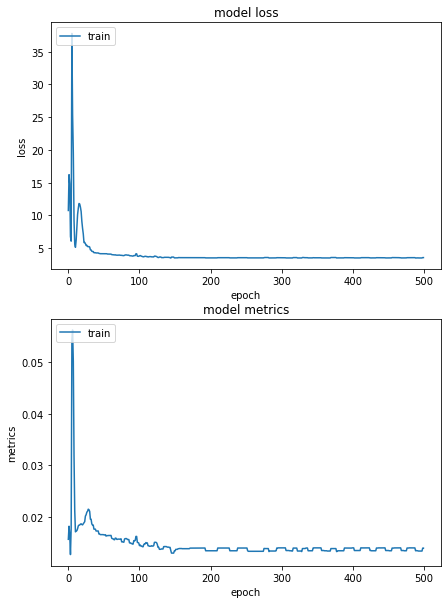

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
ax[0].plot(history.history['loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[1].plot(history.history['mae'])
ax[1].set_title('model metrics')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

In [13]:
output_audio = model(input_audio)

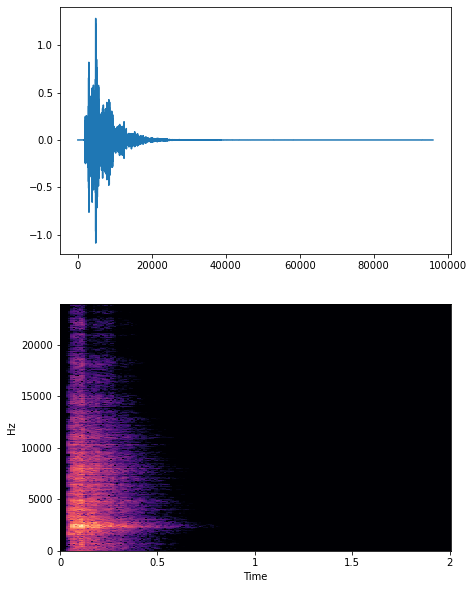

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
ax[0].plot(audio_pre)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_pre)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1])

Text(0.5, 1.0, 'Spectrogram of target audio')

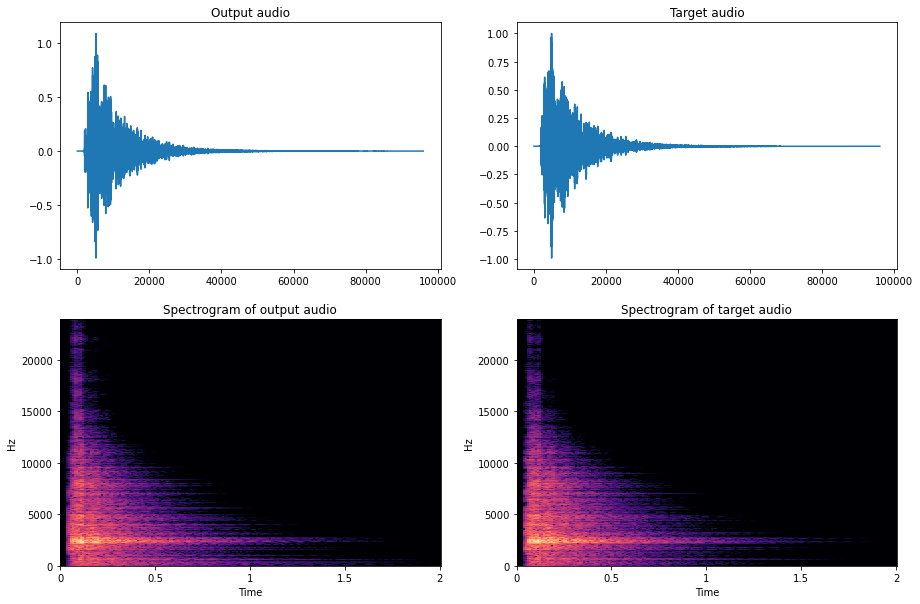

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0,0].plot(output_audio.numpy()[0])
ax[0,0].set_title("Output audio")
D = librosa.amplitude_to_db(np.abs(librosa.stft(output_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,0])
ax[1,0].set_title("Spectrogram of output audio")
ax[0,1].plot(target_audio.numpy()[0])
ax[0,1].set_title("Target audio")
D = librosa.amplitude_to_db(np.abs(librosa.stft(target_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,1])
ax[1,1].set_title("Spectrogram of target audio")

In [16]:
IPython.display.Audio(output_audio, rate=sample_rate, autoplay=True)

In [17]:
IPython.display.Audio(audio_pre, rate=sample_rate)

In [18]:
IPython.display.Audio(target_audio, rate=sample_rate)

In [19]:
# Dump values to .csv files
np.savetxt("output_audio.csv", output_audio.numpy()[0], delimiter=",")
np.savetxt("target_audio.csv", target_audio.numpy()[0], delimiter=",")

In [20]:
from scipy.io.wavfile import write
write("output_audio.wav", sample_rate, output_audio.numpy()[0].astype(np.int16))
write("target_audio.wav", sample_rate, target_audio.numpy()[0].astype(np.int16))

In [21]:
parameters = parameter_model(input_audio)

In [22]:
params = parameters.numpy()[0]
filter_c = 1
for i in range(num_params):
    if i < 16:
        print("b_%i = %f" % (i, params[i]))
    elif i < 32:
        print("c_%i = %f" % (i-4, params[i]))
    else:
        j = (i-32) % 5
        
        if j is 0:
            print("\nFilter %i:" % filter_c)
            filter_c = filter_c + 1
            print("c_hp = %f" % params[i])
        elif j is 1:
            print("c_bp = %f" % params[i])
        elif j is 2:
            print("c_lp = %f" % params[i])
        elif j is 3:
            print("g = %f" % params[i])
        elif j is 4:
            print("R = %f" % params[i])

b_0 = 0.558058
b_1 = 0.531337
b_2 = 0.549981
b_3 = 0.518748
b_4 = 0.622477
b_5 = 0.544072
b_6 = 0.494189
b_7 = 0.566581
b_8 = 0.482510
b_9 = 0.624066
b_10 = 0.493244
b_11 = 0.591959
b_12 = 0.470408
b_13 = 0.472710
b_14 = 0.520510
b_15 = 0.506766
c_12 = 0.498017
c_13 = 0.524577
c_14 = 0.444538
c_15 = 0.473556
c_16 = 0.511672
c_17 = 0.584089
c_18 = 0.545512
c_19 = 0.513415
c_20 = 0.571333
c_21 = 0.484063
c_22 = 0.516514
c_23 = 0.593119
c_24 = 0.473877
c_25 = 0.547117
c_26 = 0.528961
c_27 = 0.484180

Filter 1:
c_hp = 0.394797
c_bp = 0.478088
c_lp = 0.582351
g = 0.538910
R = 0.558529

Filter 2:
c_hp = 0.443147
c_bp = 0.443772
c_lp = 0.569734
g = 0.563360
R = 0.415189

Filter 3:
c_hp = 0.425260
c_bp = 0.429481
c_lp = 0.574760
g = 0.568842
R = 0.535147

Filter 4:
c_hp = 0.481173
c_bp = 0.468784
c_lp = 0.483728
g = 0.490824
R = 0.477718

Filter 5:
c_hp = 0.479661
c_bp = 0.417319
c_lp = 0.572372
g = 0.591134
R = 0.503228

Filter 6:
c_hp = 0.417465
c_bp = 0.494903
c_lp = 0.624384
g = 0.506089
R

(-1.0, 1.0)

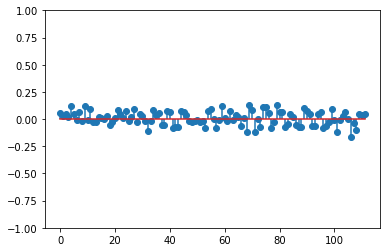

In [23]:
param_diff = params - old_params
plt.stem(param_diff)
plt.ylim([-1, 1])